# Group 4: 3D Coordinates
Generating 3D coordinates from smiles formulas using openbabel.

In [1]:
import openbabel as ob
import pybel
import pandas as pd

from io import StringIO
from ase.constraints import FixInternals
from ase.optimize import BFGS
from ase.io.xyz import read_xyz
from ase import Atoms
import networkx as nx

Make the molecule object:

In [2]:
test_smiles = "O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+](=O)[O-])c([N+](=O)[O-])c1"

obConversion = ob.OBConversion()
obConversion.SetInAndOutFormats("smi", "smi")

# Make a molecule object using the openbabel C++ wrapper:
mol_ob = ob.OBMol()

# Note that this function stores the molucule information in the mol_ob object: 
obConversion.ReadString(mol_ob, test_smiles)

True

Now we can convert this openbabel molecule into a pybel object, which is a python package extending more functionality of openbabel into python more smoothly:

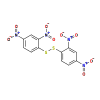

In [3]:
mol_pybel = pybel.Molecule(mol_ob)
mol_pybel

For some reason some of the dependencies are not installed properly—pybel doesn seem to be able to display images properly. But it doesn't appear to be a big problem since we don't necessarily need that.

In [4]:
mol_pybel.draw()

ImportError: Tkinter or Python Imaging Library not found, but is required for image display. See installation instructions for more information.

We want to generate 3D coordinates, so look in the list of output forms availible to see which one is appropriate:

In [5]:
pybel.outformats

{'acesin': 'ACES input format',
 'adf': 'ADF cartesian input format',
 'alc': 'Alchemy format',
 'ascii': 'ASCII format',
 'bgf': 'MSI BGF format',
 'box': 'Dock 3.5 Box format',
 'bs': 'Ball and Stick format',
 'c3d1': 'Chem3D Cartesian 1 format',
 'c3d2': 'Chem3D Cartesian 2 format',
 'cac': 'CAChe MolStruct format',
 'caccrt': 'Cacao Cartesian format',
 'cache': 'CAChe MolStruct format',
 'cacint': 'Cacao Internal format',
 'can': 'Canonical SMILES format',
 'cdjson': 'ChemDoodle JSON',
 'cdxml': 'ChemDraw CDXML format',
 'cht': 'Chemtool format',
 'cif': 'Crystallographic Information File',
 'ck': 'ChemKin format',
 'cml': 'Chemical Markup Language',
 'cmlr': 'CML Reaction format',
 'com': 'Gaussian 98/03 Input',
 'confabreport': 'Confab report format',
 'CONFIG': 'DL-POLY CONFIG',
 'CONTCAR': 'VASP format',
 'CONTFF': 'MDFF format',
 'copy': 'Copy raw text',
 'crk2d': 'Chemical Resource Kit diagram(2D)',
 'crk3d': 'Chemical Resource Kit 3D format',
 'csr': 'Accelrys/MSI Quanta CSR

We want the `'xyz': 'XYZ cartesian coordinates format'` option. So take the pybel molecule, tell pybel to make it 3D, and then print out the cooredinates whih are stored in the pybel molecule object:

In [6]:
mol_pybel.make3D()
coord = mol_pybel.write(format='xyz')
print(coord)

32

O          1.03547        0.03324       -0.05087
N          2.27364       -0.00256       -0.03902
O          2.97516       -0.86912       -0.57295
C          2.96197        1.09428        0.63110
C          2.45826        2.37923        0.46453
C          3.05611        3.43684        1.14783
C          4.21708        3.26666        1.93210
S          4.60090        4.64022        3.06151
S          4.27232        6.39631        2.01933
C          5.31621        7.69819        2.70824
C          4.71842        8.99085        2.63378
C          5.43259       10.17014        2.91320
C          6.72821       10.07510        3.40858
N          7.54684       11.27911        3.61544
O          7.04416       12.37266        3.32175
O          8.69807       11.12264        4.04097
C          7.29033        8.82057        3.64220
C          6.62974        7.64281        3.21395
N          7.48967        6.44928        3.20896
O          8.46584        6.45244        3.96194
O          7.266

Using applied-ai-for-materials/optimal-experimental-design/assignment/confutils.py as a template, convert these coordinates into ASE objects to get them ready for shnet:  
(Note some of this code is dupplicated in 4Dor2D.ipynb)

In [7]:
# Convert it to ASE
atoms = next(read_xyz(StringIO(mol_pybel.write('xyz')), slice(None)))

# Get the bonding graph
g = nx.Graph()
g.add_nodes_from(range(len(mol_pybel.atoms)))
for bond in ob.OBMolBondIter(mol_pybel.OBMol):
    g.add_edge(bond.GetBeginAtomIdx() - 1, bond.GetEndAtomIdx() - 1, data={"rotor": bond.IsRotor()})

Visualize the results:

Atoms(symbols='ONOC4S2C4NO2C2NO2CNO2CH6', pbc=False)
The generated graph:


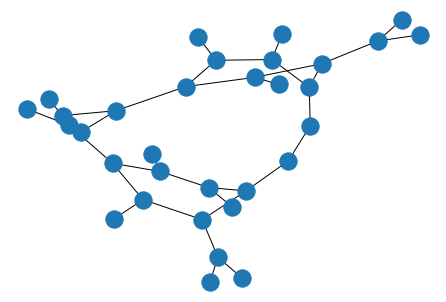

In [8]:
print(atoms)
print('The generated graph:')
nx.draw(g)

Combine all of the above into a function we can use in a pipeline:

In [9]:
def gen_3D_strings(data: pd.DataFrame, smi_col_name: str) -> pd.DataFrame:
    '''Given a pd.DataFramw with a column of similes, creates xyz column with strings
    of the 3D coordinates generated from pybel.'''
    
    def get_coords(smi: str) -> str:
        '''Function to applied element wise to pd.Series of smiles strings.'''
        
        # Set the correct input type:
        obConversion = ob.OBConversion()
        obConversion.SetInAndOutFormats("smi", "smi")

        # Make a molecule object using the openbabel C++ wrapper:
        mol_ob = ob.OBMol()

        # Note that this function stores the molucule information in the mol_ob object: 
        obConversion.ReadString(mol_ob, smi)
        
        # Pass this molecule into pybel to get coordinates:
        mol_pybel = pybel.Molecule(mol_ob)
        mol_pybel.make3D()
        coord = mol_pybel.write(format='xyz')
        
        return coord
        
    data['xyz'] = data[smi_col_name].map(get_coords)
    
    return data

Test the function on a small sample:

In [11]:
data_samp = pd.read_csv('./data/HIV.csv').sample(10)
data_samp = gen_3D_strings(data_samp, 'smiles')
data_samp

,smiles,activity,HIV_active,xyz
40192,COc1cc(C=C2C(=O)N(c3cccc(NC(C)=O)c3)C(c3ccccc3...,CI,0,63\n\nC 0.94993 -0.03266 ...
12535,BrN1C2c3ccccc3C1c1ccccc12,CI,0,26\n\nBr 1.17919 0.05631 ...
11488,COc1ccc(C=C(NC(=O)c2ccccc2)c2nc3ccccc3[nH]2)cc1OC,CI,0,51\n\nC 0.97399 0.27942 ...
1181,OCC(O)C(O)C(O)C(O)c1nc2ccccc2s1,CI,0,34\n\nO 0.98453 0.08968 ...
1357,Nc1cccc2c1C(=O)c1cccc(NC(=O)c3ccc4c5c(nsc35)-c...,CI,0,52\n\nN 0.92663 0.25144 ...
11135,CN=C(N=c1ssc(=NC)n1C)N(C)C.[O-][Cl+3]([O-])([O...,CM,1,36\n\nC 0.84103 0.11340 ...
8045,Cc1cc(S)c2cc3c(cc2n1)OCO3,CI,0,24\n\nC 1.11211 0.05301 ...
29992,O=S(=O)(NN=C1CC2CCC1C2)c1ccccc1,CI,0,34\n\nO 1.05212 0.00352 ...
32800,COc1ccc(C2CC(=O)CC(c3ccc(OC)cc3)C23C(=O)c2cccc...,CI,0,57\n\nC 1.07283 -0.06197 ...
19336,Cc1occc1C(=S)Nc1ccc(Cl)c(C(=O)OC(C)(C)C)c1,CA,1,41\n\nC 0.89588 0.18894 ...


Everything looks good so now processing the whole HIV dataset:

In [12]:
data = pd.read_csv('./data/HIV.csv')
data = gen_3D_strings(data, 'smiles')

In [13]:
data

,smiles,activity,HIV_active,xyz
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,43\n\nC 0.93683 -0.05605 ...
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,67\n\nC 1.07064 -0.06481 ...
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,34\n\nC 1.07053 0.16374 ...
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,38\n\nN 1.04278 0.02315 ...
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,16\n\nO 1.16595 0.12016 ...
...,...,...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,CI,0,57\n\nC 0.95955 0.06333 ...
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,CI,0,68\n\nC 0.96231 -0.06258 ...
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,CI,0,65\n\nC 1.01685 -0.00827 ...
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,CI,0,65\n\nC 1.07422 -0.09504 ...


Note that there were a few warnings in the terminal after running the whole thing. It appears a few molcules had some exotic geometry:

    ==============================  
    *** Open Babel Warning  in ParseComplex  
      Illegal aromatic element te  
    ==============================

But doesn't seem to have cause any problems.

Save the results to a new csv:

In [14]:
data.to_csv('./data/HIV_with_3D.csv')

### Aside:

_Dead end code that was abandonded:_  


Tried working directly with the `openbabel` module, and ran into issues with C++ pointers:  
(The pyble code above is much better)

In [15]:
test_smiles = "O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+](=O)[O-])c([N+](=O)[O-])c1"

mol_ob = ob.OBMol()

obConversion.ReadString(mol_ob, test_smiles)

True

In [16]:
builder = ob.OBBuilder()
builder.Build(mol_ob)

True

In [17]:
mol_ob.Has3D()

True

In [18]:
mol_ob.GetCoordinates()

<Swig Object of type 'double *' at 0x7f8258020930>

This appears to be a C++ pointer object, and we don't know how to handle that in python.